In [1]:
import os
import numpy as np
import sklearn as sk
import h5py

In [2]:
def get_count_trajectory(fname, cache_fname=None):
    if cache_fname and os.path.exists(cache_fname):
        return np.load(cache_fname)
    else:
        dtraj = []
        if os.path.exists(fname):
            with h5py.File(fname) as f:
                traj = f["readdy/trajectory"]
                traj_time = traj["time"]
                traj_time_records = traj["records"]
                for time, records in zip(traj_time, traj_time_records):
                    current_counts = [0]*4
                    for record in records:
                        type_id = record["typeId"]
                        current_counts[type_id] += 1
                    dtraj.append(current_counts)
        else:
            log.warn("file {} did not exist".format(fname))
        dtraj = np.array(dtraj)
        if cache_fname:
            np.save(cache_fname, dtraj)
        return dtraj
def get_count_trajectory_n_particles_obs(fname, cache_fname=None):
    with h5py.File(fname) as f:
        return f["readdy/observables/n_particles/data"][:].astype(np.double)

In [3]:
counts = get_count_trajectory_n_particles_obs("../generate/simple_trajectory_.h5", cache_fname='counts_traj_2.npy')
counts = counts[:45*500]
print(np.max(counts[:, 3]))

3188.0


In [4]:
time_step = .01
dcounts_dt = np.gradient(counts, axis=0)
print(counts.shape)
print("max counts = {}, min counts = {}".format(np.max(counts), np.min(counts[np.nonzero(counts)])))

(22500, 4)
max counts = 6000.0, min counts = 1.0


# mean field model

In [5]:
theta1 = lambda x: x[:,0]
theta2 = lambda x: x[:,1]
theta3 = lambda x: x[:,2]
theta4 = lambda x: x[:,0]*x[:,1]
theta5 = lambda x: x[:,0]*x[:,2]
theta6 = lambda x: x[:,1]*x[:,2]

In [6]:
theta = np.array([theta1(counts), theta2(counts), theta3(counts), theta4(counts), theta5(counts), theta6(counts)])

In [7]:
# theta in R^(species x ansatz functions * n_timesteps)
print(theta.shape)

(6, 22500)


In [8]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=1, positive=True)
clf.fit(theta.T, dcounts_dt)

/home/mho/miniconda2/envs/readdy_dev/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=True, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [9]:
print(dcounts_dt.shape)
print(theta.shape)

(22500, 4)
(6, 22500)


In [10]:
print(clf.coef_)

[[  0.00000000e+00   0.00000000e+00   3.64252109e-04   0.00000000e+00
    0.00000000e+00   3.69458475e-08]
 [  0.00000000e+00   0.00000000e+00   1.28981969e-04   0.00000000e+00
    0.00000000e+00   3.89371597e-08]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.91796602e-08
    1.86586066e-09   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.95457237e-08
    1.00287058e-08   7.51698880e-09]]


# Simon way (solve for all times indepdenently, use markov property)

In [11]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=15, warm_start=False, max_iter=1000, tol=1e-6, positive=True)

In [12]:
theta1 = lambda x: np.array([-x[0]*x[1], -x[0]*x[1], x[0]*x[1], 0])
theta2 = lambda x: np.array([x[2], x[2], -x[2], 0])
theta3 = lambda x: np.array([-x[0], x[0], 0, 0])
theta5 = lambda x: np.array([-x[0], 0, 0, x[0]])

In [13]:
n_timesteps = counts.shape[0]

In [14]:
alphas = []
for i in range(0, n_timesteps):
    c = counts[i]
    theta = np.array([theta1(c), theta2(c), theta3(c), theta5(c)])
    dc = dcounts_dt[i] / time_step
    clf.fit(theta.T, dc)
    alphas.append(clf.coef_)

In [15]:
xi = np.sum(alphas, axis=0) / len(alphas)
print("xi = %s" % xi)

xi = [  1.70342302e-06   0.00000000e+00   0.00000000e+00   1.03512901e-02]


In [16]:
from scipy.integrate import odeint

In [17]:
def fun(data, _):
    theta = np.array([theta1(data), theta2(data), theta3(data), theta5(data)])
    return np.matmul(xi, theta)

In [18]:
num_solution = odeint(fun, counts[0], np.arange(0, n_timesteps*.01, .01))

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

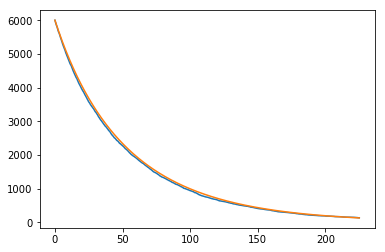

In [20]:
plt.plot(np.arange(0, n_timesteps*.01, .01), counts[:,0])
plt.plot(np.arange(0, n_timesteps*.01, .01), num_solution[:, 0])

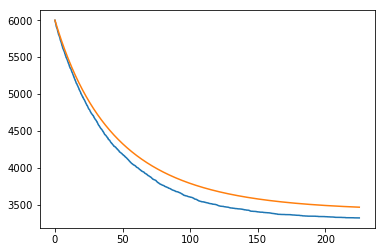

In [21]:
plt.plot(np.arange(0, n_timesteps * .01, .01), counts[:,1])
plt.plot(np.arange(0, n_timesteps * .01, .01), num_solution[:, 1])

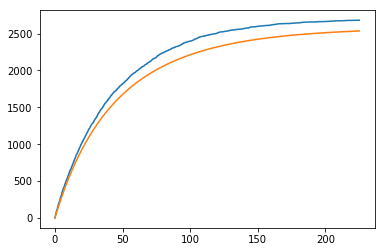

In [22]:
plt.plot(np.arange(0, n_timesteps * .01, .01), counts[:,2])
plt.plot(np.arange(0, n_timesteps * .01, .01), num_solution[:, 2])

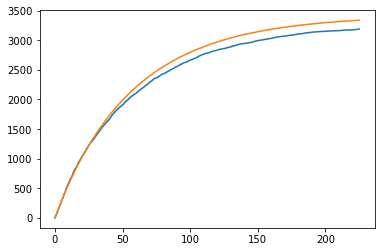

In [23]:
plt.plot(np.arange(0, n_timesteps * .01, .01), counts[:,3])
plt.plot(np.arange(0, n_timesteps * .01, .01), num_solution[:, 3])

In [24]:
diffusion_coeff = 0.2 
micro_rate = 0.05
reaction_radius = 0.7
tmp = np.sqrt(micro_rate / diffusion_coeff) * reaction_radius
rate_chapman = 4. * np.pi * diffusion_coeff * reaction_radius * (1. - np.tanh(tmp) / tmp)

In [25]:
print("erban chapman rate (per volume): {}".format(rate_chapman))
print("lasso fitted rate (per counts): {}".format(xi[0]))
print("lasso fitted rate (per volume): {}".format(xi[0] * 15 * 15 * 15))

erban chapman rate (per volume): 0.06848398371542153
lasso fitted rate (per counts): 1.703423022972958e-06
lasso fitted rate (per volume): 0.005749052702533734
